# Personal Finance Subreddit Capstone Project

## Data Wrangling

The goal of this notebook is to extract data containing information about the personal finance subreddit from Reddit's API, select interesting features that can be relevant to the project and clean the dataset so that it is ready for data exploration.

- **Import the necessary packages**

In [93]:
import praw
import pandas as pd
import numpy as np
import datetime
import json
import requests
import string
import time
import datetime
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

- **Extract the data from reddit using pushshift**

In [15]:
# Variables
sub    = 'personalfinance'     # name of the subreddit you would like to scrape
after  = '2018-08-01'    # earliest date that will be scraped
before = '2018-09-19'    # latest date that will be scraped
fast   = True           # True will be faster, won't pull upvote ratio

In [ ]:
# Initiate sqlite
sql = sqlite3.connect('personalfinance_.db')
cur = sql.cursor()
cur.execute('CREATE TABLE IF NOT EXISTS posts (name TEXT, title TEXT, readable_utc TEXT, permalink TEXT, domain TEXT, url TEXT, author TEXT, score TEXT, upvote_ratio TEXT, num_comments TEXT)')
sql.commit()
print('Loaded SQL Database and Tables')

# Convert the specified dates to strptime
after = time.mktime(datetime.datetime.strptime(after, '%Y-%m-%d').timetuple())
after = int(after)
readable_after = time.strftime('%d %b %Y %I:%M %p', time.localtime(after))
before = time.mktime(datetime.datetime.strptime(before, '%Y-%m-%d').timetuple())
before = int(before) + 86399
readable_before = time.strftime('%d %b %Y %I:%M %p', time.localtime(before))
print('Searching for posts between ' + readable_after + ' and ' + readable_before + '.')
currentDate = before

Using pushshift will allow us to retrieve valuable information from reddit submissions including:
- Submission ID
- Submission title
- Submission date
- Submission permalink
- Submission domain
- Submission url
- Submission author
- Submission score (upvotes)
- Submission upvote_ratio (ratio of upvotes to downvotes)
- Submission number of comments

However, it does not provide us with the flair information.

In [ ]:
# Perform a new full pull from Pushshift
def newpull(thisBefore):
    global currentDate
    readable_thisBefore = time.strftime('%d %b %Y %I:%M %p', time.localtime(thisBefore))
    print('Searching posts before ' + str(readable_thisBefore))
    url = 'http://api.pushshift.io/reddit/search/submission/?subreddit=' + sub + '&size=500&before=' + str(thisBefore)
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print('    Discussion: HTML Error - ', response.status_code)
        time.sleep(60)
        return
    curJSON = response.json()

    # Update each Pushshift result with Reddit data
    for child in curJSON['data']:

        # Check to see if already added
        name = str(child['id'])
        cur.execute('SELECT * FROM posts WHERE name == ?', [name])
        if cur.fetchone():
            print(str(child['id']) + ' skipped (already in database)')
            continue

        # If not, get more data
        if fast is True:
            searchURL = 'http://reddit.com/by_id/t3_'
        else:
            searchURL = 'http://reddit.com/'
        url = searchURL + str(name) + '.json'
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'}
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print('    Discussion: HTML Error - ', response.status_code)
            time.sleep(60)
            break
        postJSON = response.json()
        if fast is True:
            jsonStart = postJSON
        else:
            jsonStart = postJSON[0]

        # Check to see if Date has passed
        global currentDate
        created_utc = jsonStart['data']['children'][0]['data']['created_utc']
        currentDate = int(created_utc)
        if currentDate <= after:
            break

        # If not, process remaining data
        try:
            title = str(jsonStart['data']['children'][0]['data']['title'])  # Checks for emojis and other non-printable characters
        except UnicodeEncodeError:
            title = ''.join(c for c in str(jsonStart['data']['children'][0]['data']['title']) if c in string.printable)
        readable_utc = time.strftime('%d %b %Y %I:%M %p', time.localtime(created_utc))
        permalink    = (str(jsonStart['data']['children'][0]['data']['permalink']))
        domain       = (str(jsonStart['data']['children'][0]['data']['domain']))
        url          = (str(jsonStart['data']['children'][0]['data']['url']))
        author       = (str(jsonStart['data']['children'][0]['data']['author']))
        score        = (str(jsonStart['data']['children'][0]['data']['score']))
        num_comments = (str(jsonStart['data']['children'][0]['data']['num_comments']))
        if fast is True:
            upvote_ratio = 0
        else:
            upvote_ratio = (str(jsonStart['data']['children'][0]['data']['upvote_ratio']))

        # Write it to SQL Database
        cur.execute('INSERT INTO posts VALUES(?,?,?,?,?,?,?,?,?,?)', [name, title, readable_utc, permalink, domain, url, author, score, upvote_ratio, num_comments])
        sql.commit()

# Run the newpull
while currentDate >= after:
    newpull(currentDate)

In [ ]:
connection = sqlite3.connect("personalfinance_.db") 
  
# cursor object 
crsr = connection.cursor() 
  
# execute the command to fetch all the data from the table emp 
crsr.execute("SELECT * FROM posts")  
  
# store all the fetched data in the ans variable 
ans= crsr.fetchall()  

# Create dataframe
columns = ['title']
index = range(0,2)
df = pd.DataFrame(index = index, columns = columns)
df = df.fillna(0)

for n, i in enumerate(ans):
    # Create title column
    df.loc[n , 'title'] = i[1]
    # Create date column
    df.loc[n , 'date'] = i[2][:-8]
    # Create time column
    df.loc[n , 'time'] = i[2][-8:]
    # Create upvote column
    df.loc[n , 'upvotes'] = i[7]
    # Create id column
    df.loc[n , 'id'] = i[0]

- **Retrieve flair information from Reddit's API**

In [2]:
# Create new Reddit instance
reddit = praw.Reddit(client_id='wCVLQpLadsfujg',
                     client_secret='OYQ0wdFFqvYh_KMrXDG_Xg9SBNQ',
                     user_agent='python.project (by /u/AKoreanEngima)',
                    username = 'AKoreanEngima',
                    password = 'gr8104010')

In [ ]:
for a,b in enumerate(df.id):
    df.loc[a, 'topic'] = reddit.submission(id = "{}".format(b)).link_flair_text

In [ ]:
# Sort by date
df.sort_values(by = 'date', ascending = False, inplace=True)
# Save as .csv file
df.to_csv(r'C:\Users\joshu\Downloads\Data\reddit\reddit_pf.csv')

In [178]:
# Open file
df = pd.read_csv(r'C:\Users\joshu\Downloads\Data\reddit\reddit_pf.csv')

In [179]:
# Drop the unnamed column.
df.drop('Unnamed: 0',axis=1, inplace=True)

- **Convert Dates into datetime format**

In [46]:
b = df.date[10000]
df.loc[a, 'date'] = datetime.strptime(b, '%d %b %Y ').date()

In [51]:
# for a,b in enumerate(df.date):
#     df.loc[a, 'date'] = datetime.strptime(b, '%d %b %Y ').date()
# df = df.sort_values(by='date', ascending = False).reset_index().drop('index',axis='columns')

In [52]:
df.head()

,title,date,time,upvotes,id,topic
0,Credit card raised my limit without me asking....,2018-08-31,11:59 PM,0,9c06kj,Credit
1,An automatic recurring membership was billed f...,2018-08-31,09:27 PM,1,9bz9q8,Debt
2,Started a 401k @ 30 years old. First check hit...,2018-08-31,02:17 PM,13,9bw0vk,Investing
3,New Job vs. Counter Offer; What Do I Do?,2018-08-31,11:57 PM,6,9c062g,Employment
4,I need health insurance and I don't know what ...,2018-08-31,11:51 PM,3,9c04yk,Insurance


## **Explore the data**

- Note: For the sake of clarity, this project will use **"topic"** to describe the actual topic that was assigned to each submission while **"subject"** will refer to the generated/artificial topic that was extracted from the data.

In [71]:
# Top 10 most popular topics (flairs)
df.topic.value_counts()[0:10]

Debt          1256
Other         1205
Credit        1048
Investing      859
Retirement     824
Employment     724
Housing        709
Auto           560
Planning       526
Saving         524
Name: topic, dtype: int64

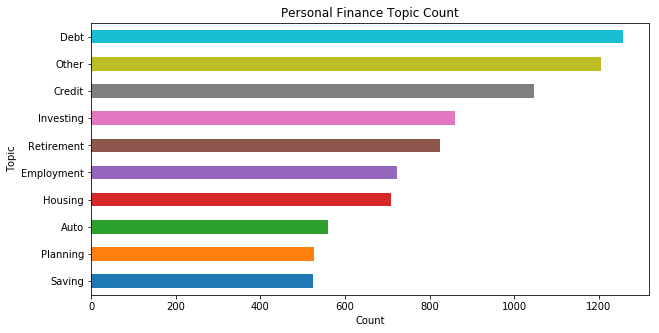

In [81]:
plt.figure(figsize = (10,5))
df.topic.value_counts()[0:10][::-1].plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.title('Personal Finance Topic Count')
plt.show()

- Debt is the most popular topic in the personal finance subreddit, followed by Other and Credit. This indicates that debt is a major concern for many of the redditors (users) and they make submissions in order to seek advice.

- Other would include topics that don't match the default topics. With more data, it could be possible that Other is the most popular topic instead of Debt.

- Investment and Retirement are also similar in their counts while also being very similar in their functions.

- Let's look at the top 10 most popular submissions by sorting them by the number of upvotes.

In [57]:
# Top 10 most popular headlines
[title for title in df.sort_values(by='upvotes', ascending=False)['title'].values[:10]]

["IRS will allow employers to match their employees' student loan repayments",
 'Your amazon store card is probably scamming you',
 'So I fell for a scam yesterday and it still angers me.',
 'Wife passed away. I would truly appreciate some help figuring out where I stand.',
 'Bought a car today. Transmission went out 60 miles from the car lot and everyone had gone home for the day. Is there any chance I can get a refund?',
 'My girlfriend is being offered a too good to be true job with little to no personal history with employer.',
 'Do I need a credit card? I have been strongly advised against it by my parents who say its a scam and should be illegal but everything I look at says that no credit is just as bad if not worse than low credit. What should I do?',
 '[US] Paypal account balance is -$2000. What can they do?',
 'Why You Might Consider A Trade Over College (One Real-World Perspective)',
 '"Hidden" costs of buying a home and how to prepare for them.']

- There are a variety of different subjects in the top 10 most popular posts, ranging from scams to dealing with the loss of a family member.

- However, 3 of the top 10 include the word "scam", showing that this may be a popular subject in /r/personalfinance and could happen often. This could be a common issue among many people living in the US.

- While some posts are seeking advice, others provide advice such as '"Hidden" costs of buying a home and how to prepare for them.'



- Next let's import the nltk package and use the set of stopwords to extract key words from the 20 most popular submissions. 

In [54]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

stopwords = set(stopwords.words('english'))

In [87]:
best_titles = df.sort_values(by='upvotes', ascending=False)['title'].values[:20]
best_words = set(np.concatenate([word_tokenize(t) for t in best_titles])) - stopwords
best_words = {word.lower() for word in best_words}
best_words = best_words - set(string.punctuation) - set(string.digits)

def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

best_words = {word for word in best_words if not is_float(word)}

best_words = {word for word in best_words if "'" not in word}  # drop contractions

In [88]:
pd.Series(index=list(best_words)[:25], data=[(df[df['title'].map(lambda title: word in title)]['upvotes'].mean(),
                                             df[df['title'].map(lambda title: word in title)]['upvotes'].count())
                                            for word in list(best_words)[:25]])

passed            (895.9615384615385, 26)
keep             (74.00980392156863, 102)
selling                       (150.2, 40)
transmission                     (5.6, 5)
probably                     (2598.7, 10)
should          (29.550321199143468, 467)
scam              (729.9571428571429, 70)
fund             (79.38325991189427, 227)
20,000            (349.7142857142857, 21)
live              (97.10526315789474, 76)
figuring                    (1536.375, 8)
1.8k                          (6808.0, 1)
mistake           (305.9047619047619, 21)
prove            (125.15254237288136, 59)
so              (47.140946502057616, 972)
lot                           (245.5, 42)
might            (19.058823529411764, 17)
over            (40.800586510263926, 341)
do              (41.39578005115089, 1564)
face               (964.8333333333334, 6)
employers         (4081.5555555555557, 9)
account         (101.39088729016787, 417)
situation         (82.95348837209302, 86)
one              (32.1699078812691

- As we can see, there are a lot of words that are very situational in nature such as "probably", "should", "might", "situation".

- Some words can give us an idea of what the topic is about such as "transmission", "scam", "fund", "employers".

- However other words are ambiguous and could have multiple implications such as "passed", "live", "lot", "account".



- Let's specifically look at cases where "passed" is in the title to observe its connotation and context in /r/personalfinance.

In [68]:
df[df['title'].map(lambda title: 'passed' in title)].head(10)

,title,date,time,upvotes,id,topic
890,"Father passed away, mother not on mortgage or ...",2018-08-30,12:06 AM,1,9bgdx1,Other
1429,Both parents passed away abruptly. Going solo ...,2018-08-28,09:21 PM,3758,9b4t7o,Other
1949,"An aunt passed away, a while ago my mother sha...",2018-08-27,08:28 PM,1,9aub1n,Other
2001,"26 Years Old, Mom just passed away and around ...",2018-08-27,06:33 PM,14,9ath0l,Debt
2371,"[TX] Bro in law passed away with no will, need...",2018-08-27,12:15 AM,3,9alxol,Other
2456,"Dad passed away, what's the best way to set my...",2018-08-26,07:01 PM,9,9ajtyn,Other
2476,Father passed away - help locating banking inf...,2018-08-26,05:34 PM,1,9aj7eh,Saving
2985,"Mum passed away a few years ago, looking for t...",2018-09-19,06:52 AM,0,9h445e,Investing
4283,"[UK] 25, just entered into 5yr mortgage fixtur...",2018-09-16,05:38 AM,2,9g9e0r,Housing
4356,Dad passed in December. Mom lives in AZ and on...,2018-09-15,10:44 PM,1,9g7ays,Other


- It's now clear that it is mostly used to sadly describe the passing away of a family member. 

- When looking at the topics, these submissions mostly fall under "Other" while the rest fall under a variety of topics such as Debt or Housing.



- Next let's tokenize the submissions using the word_tokenize() function and remove unnecessary characters (numbers, punctaation).

In [226]:
words_tokenized = [[w.lower() for w in word_tokenize(t)] for t in df['title']]
df['tokenized_title'] = words_tokenized
all_words = pd.Series(np.concatenate(words_tokenized)).value_counts()

In [90]:
all_words = all_words[[word not in stopwords for word in all_words.index]]
all_words = all_words[[word not in string.punctuation for word in all_words.index]]
all_words = all_words[[word not in string.digits for word in all_words.index]]
all_words = all_words[[not is_float(word) for word in all_words.index]]
all_words = all_words[["'" not in word for word in all_words.index]]

In [92]:
all_words[:10].index

Index(['credit', 'car', 'debt', 'need', 'card', 'money', 'loan', 'help',
       'advice', 'pay'],
      dtype='object')

- Similar to the actual default topics assigned to the submissions, the subjects we extracted using tokenization have "credit" and "debt" as the most popular words. 

- There are other key words that shed some light on the sentiments of the redditors such as "help", "advice", and "need". This is not surprising as we have seen before that many redditors come to /r/personalfinance seeking help for their debt issues.

- Next let's further analyze the words by using the PorterStemmer() function, which stems words to its root form. Ex. Articulating becomes Articulate.

In [184]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
all_words.index = [stemmer.stem(w) for w in all_words.index]
all_words[:10].index

Index(['credit', 'car', 'debt', 'need', 'card', 'money', 'loan', 'help',
       'advic', 'pay'],
      dtype='object')

- Not much has really changed for the top 10 most popular words, other than the fact that "advice" has been shortened to "advic". 



- Let's graph the list of tokenized words by their count using a scatterplot.

In [210]:
# Check the total number of words.

len(all_words)

7657

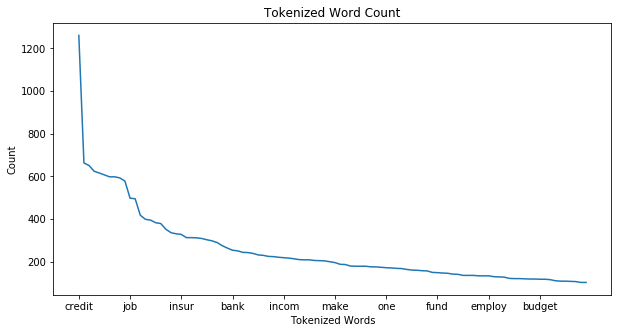

In [213]:
# Create a list of words evenly spread out by 10 in the top 100.
x = np.arange(0,100,10)
ten_words_list = []
for a in x:
    ten_words_list.append(all_words.index[a])

# Plot the words.
plt.figure(figsize = (10,5))
all_words[:100].plot()
plt.xticks(np.arange(0,100, 10), ten_words_list)
plt.xlabel('Tokenized Words')
plt.ylabel('Count')
plt.title('Tokenized Word Count')
plt.show()

- Interestingly, there is a sharp discrepency in the popularity of words between the top 3 and the rest. 

- We can see words such as job and employment are similar in their meaning but are vastly different in how frequently they come up in submission titles. This is probably due to the fact that people use "job" more colloquially than employment.

- What happens when we group by the words themselves?

In [223]:
all_stems = all_words.groupby(all_words.index).sum().sort_values(ascending=False)
all_stems[:10].index

Index(['credit', 'loan', 'pay', 'card', 'need', 'debt', 'car', 'help', 'money',
       'invest'],
      dtype='object')

- Almost all the words in the previous top 10 stayed in the top 10, except for "advic" which was replaced by "loan".

- Let's create a new column that contains the stemmed versions of the submission titles.

In [227]:
df['stemmed_title'] = df['tokenized_title'].map(lambda wl: [stemmer.stem(w) for w in wl])

In [230]:
df['stemmed_title'].head(10)

0    [credit, card, rais, my, limit, without, me, a...
1    [an, automat, recur, membership, wa, bill, for...
2    [start, a, 401k, @, 30, year, old, ., first, c...
3    [new, job, vs, ., counter, offer, ;, what, do,...
4    [i, need, health, insur, and, i, do, n't, know...
5    [about, to, get, screw, with, student, loan, r...
6                 [invest, advice/guid, for, a, newbi]
7    [wife, is, scare, that, work, will, fire, her,...
8    [massiv, debt, and, get, a, big, payment, for,...
9    [well, ,, i, 've, been, semi-retir, sinc, i, w...
Name: stemmed_title, dtype: object

- Next, let's observe how the submissions have changed over the course of time.

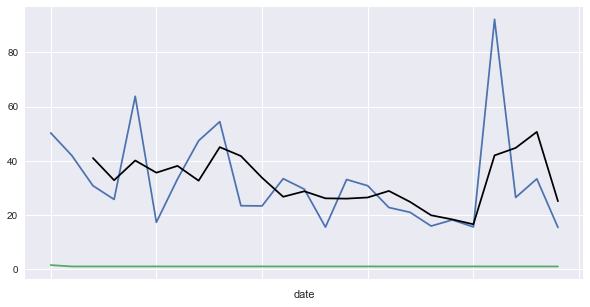

In [236]:
plt.figure(figsize=(10,5))
df.groupby('date')['upvotes'].mean().plot()
df.groupby('date')['upvotes'].median().plot()
df.groupby('date')['upvotes'].mean().rolling(window=3).mean().plot(color='black')
plt.xticks(rotation=45)
plt.show()

- **Most popular subjects**

In [127]:
from nltk import pos_tag

In [130]:
pos_tag(df['tokenized_title'][0])[0:5]

[('credit', 'NN'),
 ('card', 'NN'),
 ('raised', 'VBD'),
 ('my', 'PRP$'),
 ('limit', 'NN')]

In [132]:
df['pos_title'] = df['tokenized_title'].map(lambda t: [t[1] for t in pos_tag(t)])

In [133]:
df['pos_title'].head()

0    [NN, NN, VBD, PRP$, NN, IN, PRP, VBG, ., JJ, V...
1    [DT, JJ, VBG, NN, VBD, VBN, IN, DT, JJ, NN, ,,...
2    [VBD, DT, CD, JJ, CD, NNS, JJ, ., JJ, NN, VBN,...
3       [JJ, NN, NN, ., NN, NN, :, WP, VBP, VB, VB, .]
4    [NNS, VBP, NN, NN, CC, NN, VBP, RB, VB, WP, TO...
Name: pos_title, dtype: object

In [134]:
def topicify(srs):
    tags = srs['pos_title']
    stems = srs['stemmed_title']
    return [stem for (tag, stem) in zip(tags, stems) if tag in ['NN', 'NNS']]

In [136]:
df['gen_topics'] = df.apply(topicify, axis='columns')

In [138]:
df['gen_topics'].head()

0    [credit, card, limit, t, i, lot, credit, i, ’,...
1                       [membership, year, i, collect]
2                              [year, check, today, i]
3                            [job, vs, counter, offer]
4                                [i, health, insur, i]
Name: gen_topics, dtype: object

In [139]:
topic_counts = pd.Series(np.concatenate(df['gen_topics'].values)).value_counts()

In [140]:
topic_counts.head()

i         1543
credit    1266
loan       896
card       715
debt       680
dtype: int64

In [141]:
topic_counts[1:].head(10)

credit     1266
loan        896
card        715
debt        680
car         676
money       608
advic       593
year        548
job         544
student     488
dtype: int64

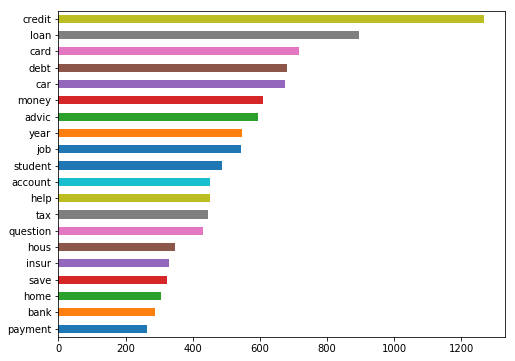

In [146]:
plt.figure(figsize=(8,6))
topic_counts[1:].head(20)[::-1].plot(kind='barh')
plt.show()

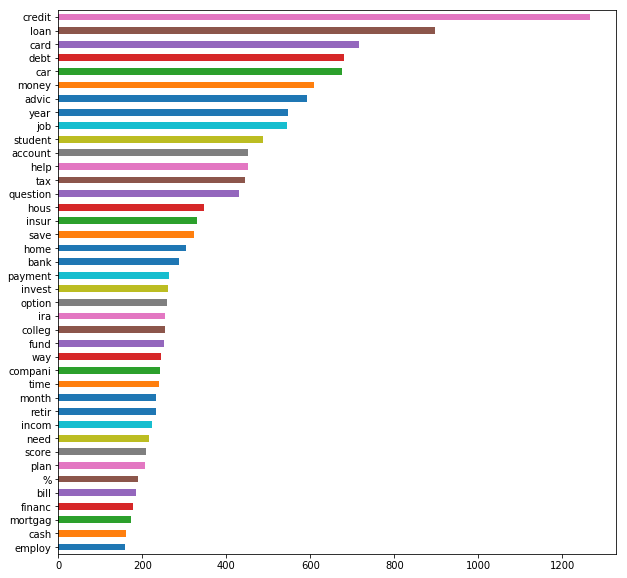

In [151]:
plt.figure(figsize=(10,10))
topic_counts[1:].head(40)[::-1].plot(kind='barh')

- **Sentiment analysis**

Let's try doing sentiment analysis using the SentimentIntensityAnalyzer function.

In [155]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [156]:
top_1000 = topic_counts.sort_values(ascending=False).head(1000)
top_1000_sentiments = [sid.polarity_scores(w)['compound'] for w in top_1000.index]

In [157]:
tmp = pd.DataFrame(top_1000).assign(sentiment=top_1000_sentiments)

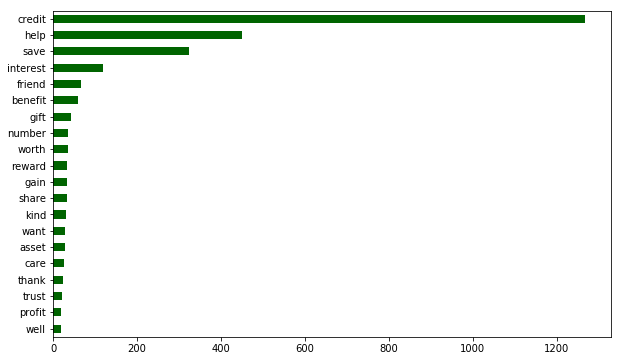

In [176]:
plt.figure(figsize=(10,6))
tmp[tmp.sentiment>0].head(20)[0][::-1].plot(kind='barh', color='darkgreen')
plt.show()

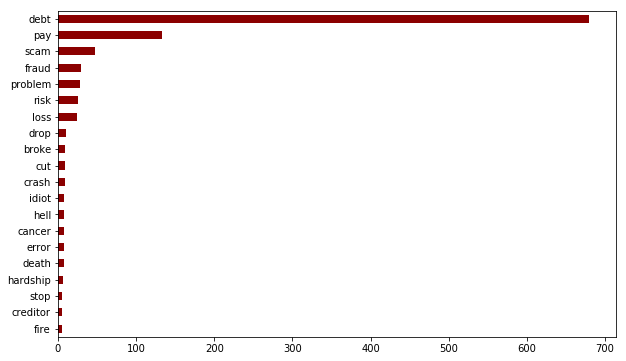

In [177]:
plt.figure(figsize=(10,6))
tmp[tmp.sentiment<0].head(20)[0][::-1].plot(kind='barh', color='darkred')
plt.show()